# このノートブックについて

DIC個人プロジェクトで発表時点までに行ったことのまとめを記載する。  

タイトル：簡易的な医療画像分類モデルの作成  

概要：予防医療や早期発見に向けた、画像分類モデルの作成を試みた。  
　　　webから取得した画像を様々なモデルを使って評価した。  
   
まとめ：医療用画像だったため、評価指標や損失関数を作成した。  
　　　　通常のCNNに加えて、CNN+SVMのモデルを作成した。  
    　　　CNN+SVMのモデルが作成した評価指標では良い数値だった。

In [71]:
import glob
import matplotlib.pyplot as plt
from Functions import process_img
from PIL import Image
import cv2

from keras.models import load_model, Sequential, Model
from keras.layers import Dense, Flatten
import  keras.backend as K
from keras.applications import VGG16
from keras.optimizers import Adam

# 目次

- 概要
- データセット
 - 取得方法
 - 前処理  
<br>
- 分類器選定
 - OpenCV
   - Edge Detection
   - Corner Detection
   - Open Pose
   - 特徴点マッチング・テンプレートマッチング
 - Segmentation→画像分類
  - 転移学習モデル  
<br>
- 検証
 - 評価指標
 - 損失関数
 - Stratified-KFold  
<br>
- GUI  
<br>
- 運用方法の検討  
<br>
- まとめ
 - 大変だったこと
 - 学んだこと
- おまけ（tiny-yoloによる物体検出）

# 概要

近年医療分野では医師の負担増加などが問題となり、機械学習で何かできないかと考えた。  
そこで、今回DICの卒業課題として**簡易的な医療画像分類モデルの作成**を行った。  

Webから取得した手の画像を、通常/へバーデン結節/関節リウマチに分類するモデルを作成し、推定した。

# データセット
## 使用するデータ

googleの画像検索から通常/へバーデン結節/関節リウマチの画像を取得した。

In [14]:
Np = "./dataset/Rheumatoid_dataset/Normal/images-4.jpeg"
Hp = "./dataset/Rheumatoid_dataset/Heberden/yjimage-8.jpeg"
Rp = "./dataset/Rheumatoid_dataset/Rheumatoid/7f7f6adf376e3872383b07d1ce3bc61b.jpeg"

In [15]:
Ni = Image.open(Np)
Hi = Image.open(Hp)
Ri = Image.open(Rp)

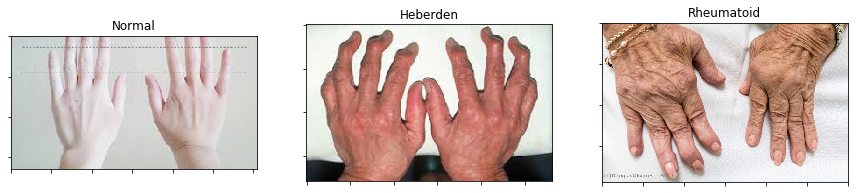

In [28]:
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Ni)
plt.title("Normal")

plt.subplot(1, 3, 2)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Hi)
plt.title("Heberden")

plt.subplot( 1, 3, 3)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Ri)
plt.title("Rheumatoid")

plt.show()

## 前処理

画像の前処理として以下のことをした。
- 手の部分だけ入るようにした。
- 両手が写っている画像を片手にした。
- 手が下から出てくるように回転させた
- 画像のshapeを(224, 224, 3)で統一した

In [29]:
Nop = "./dataset/data_reshape/image_onehand_reshape/N/12.png"
Hop = "./dataset/data_reshape/image_onehand_reshape/H/0.png"
Rop = "./dataset/data_reshape/image_onehand_reshape/R/29.png"

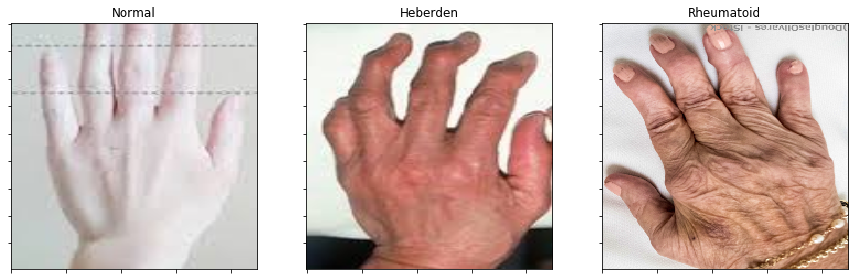

In [30]:
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Image.open(Nop))
plt.title("Normal")

plt.subplot(1, 3, 2)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Image.open(Hop))
plt.title("Heberden")

plt.subplot( 1, 3, 3)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Image.open(Rop))
plt.title("Rheumatoid")

plt.show()

# モデル
## OpenCV

OpenCVの以下の機能を用いて画像のクラス分類を試みた。  
しかし、すべて上手く行かなかった。

### Edge Detection
OpenCVのEdge Detection機能を用いて、エッジを検出しする。  
その画像を画像分類モデルで分類しようと試みたが、画像によってエッジ検出が上手くできなかったので、断念した。

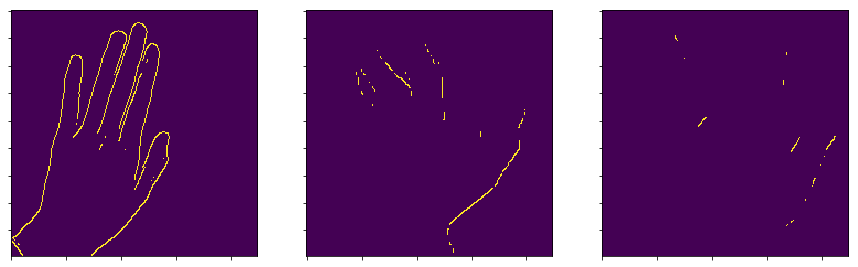

In [37]:
plt.figure(figsize=(15,15))
img_1 = cv2.imread("./dataset/data_reshape/image_onehand_reshape/N/0.png",0)
edges_1 = cv2.Canny(img_1,224,224)
plt.subplot(1, 3, 1)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(edges_1)

img_2 = cv2.imread("./dataset/data_reshape/image_onehand_reshape/N/1.png",0)
edges_2 = cv2.Canny(img_2,224,224)
plt.subplot(1, 3, 2)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(edges_2)

img_3 = cv2.imread("./dataset/data_reshape/image_onehand_reshape/N/3.png",0)
edges_3 = cv2.Canny(img_3,224,224)
plt.subplot(1, 3, 3)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(edges_3)

### Corner Detection

openCVのCorner Detection機能を用いて、Cornerを検出しそれらの座標を特徴量とすることを考えた。  
しかしこちらも画像によっては上手く検出できなかったので断念した。

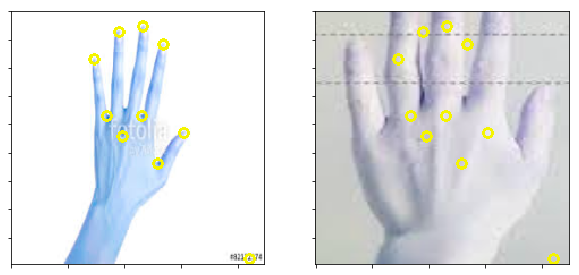

In [42]:
img1 = cv2.imread("./dataset/data_reshape/image_onehand_reshape/N/11.png")
img2 = cv2.imread("./dataset/data_reshape/image_onehand_reshape/N/12.png")

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
corners1 = cv2.goodFeaturesToTrack(gray, 10, 0.01,
                                     20.0, blockSize = 3, useHarrisDetector = False)

gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
corners2 = cv2.goodFeaturesToTrack(gray, 10, 0.01,
                                     20.0, blockSize = 3, useHarrisDetector = False)
    
for i in corners1:
    x, y = i.ravel()
    cv2.circle(img1, (x, y), 4, (244, 244, 0), 2)
for i in corners2:
    x, y = i.ravel()
    cv2.circle(img2, (x, y), 4, (244, 244, 0), 2)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(img1)

plt.subplot(1, 2, 2)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(img2)

plt.show()

### Open pose
GitHubからクローンしてきた、pytorchのOpenposeを使用して関節点を検出し、関節点の座標や関節の曲がり具合を特徴量にしようと試みた。  
しかし、画像によっては上手く検出できなかったので断念した.。

In [43]:
N_op_p = "./dataset/data_reshape/openpose_result/N/predict.png"
H_op_p = "./dataset/data_reshape/openpose_result/H/predict.png"
R_op_p = "./dataset/data_reshape/openpose_result/R/predict.png"

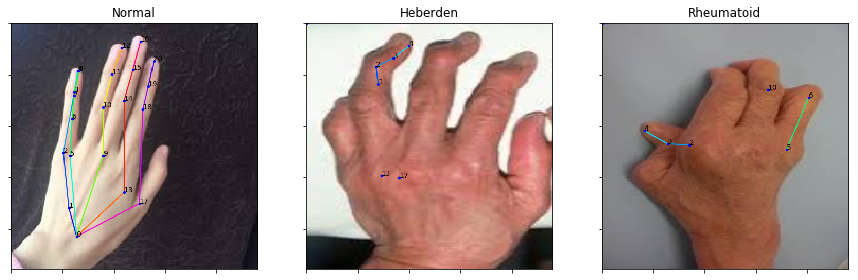

In [44]:
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Image.open(N_op_p))
plt.title("Normal")

plt.subplot(1, 3, 2)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Image.open(H_op_p))
plt.title("Heberden")

plt.subplot( 1, 3, 3)
plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(Image.open(R_op_p))
plt.title("Rheumatoid")

plt.show()

### 特徴点マッチング、テンプレートマッチング
特徴点マッチングとテンプレートマッチングも試みたが、上手くできなかった。

## Segmentation→画像分類

Unetを用いて画像をセグメンテーションし、出力された白黒画像をCNNモデルで分類すればシルエットだけを学習できるので精度が上がると考えた  
結果はaccuracy0.7であった。  

方法は以下の手順で行った。
- Labelmeで画像のアノテーション
- それを白黒画像に置き換え、保存
- UnetのGITをCloneする
- CloneしたU-netのコードを書き換える。例）入力のチャネルを"rgb"に変える等
- Unetを学習
- CNNモデルを作成し、セグメンテーションした白黒画像を用いて学習
- 推定データをU-netで推定し、出力された画像に0か255を代入し、CNNモデルで推定

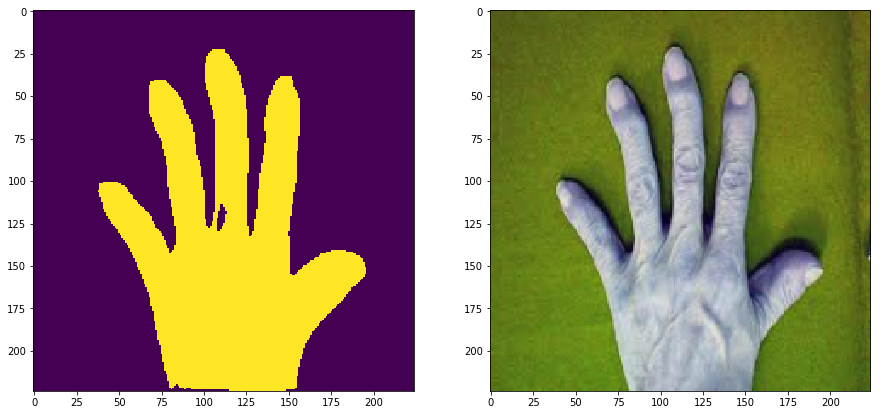

In [50]:
#Unetのoutput

seg_out_p = "seg_out.png"
seg_test_p = "seg_test.png"

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(seg_out_p))

plt.subplot(1, 2, 2)
plt.imshow(Image.open(seg_test_p))

In [54]:
#Unetからの出力をCNNで分類
#作成したCNNのsummary
cnn_model = load_model("./model/segmentation/Mmodel_pred_1.h5")
cnn_model.summary()

#結果：accuracyが0.7程度であった。

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 512)      

## 転移学習モデル

転移学習モデルとして以下のモデルを使用した。

VGG16, VGG19, ResNet50, MobileNetV2
上記のモデルを使用した理由は、転移学習させた方が学習が早くできると考えた。  
その際にkeras.applicationsで使えるモデルの方が都合がよかった。  
加えて、時間的制約のなかで学習と推定を複数回行うことを考えたときに層が浅い方が早く済むと考えた。

さらにそれらのCNNモデルとCNNモデルとSVMを連結させたものの2パターンを作成した。

CNN+SVMモデル作成、推定手順  
- 通常のCNNを作成、学習
- 上記のCNNの一部を抽出(model2)
- SVMをインスタンス化
- model2を使い学習データから出力
- 出力されたデータを使いSVMを学習
- 推定データを使いmodel2の出力を取得
- 上記の出力を使いSVMで推定

CNN + SVMモデル作成、推定例
<pre>
# 通常のCNNを作成
K.clear_session()
model = Sequential()
model.add(VGG16(include_top=False, input_shape=(224,224,3)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu", name="svm_input"))
model.add(Dense(3, activation="softmax"))
model.summary()
model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=1e-5), metrics = ["accuracy"])

#通常のCNNの学習
history = model.fit(train_x, train_y, validation_data=[val_x, val_y], epochs=50, verbose=1,
                       callbacks=[EarlyStopping(monitor="val_acc", patience=5)])
             
#上記のCNNの一部を抽出(model2)
svm_model = Model(inputs = model.input, outputs = model.get_layer("svm_input").output)

#SVMをインスタンス化
svm = SVC()

#model2を使い学習データから出力
inputs_svm = svm_model.predict(train_x)

#出力されたデータを使いSVMを学習
svm.fit(inputs_svm, np.argmax(train_y, axis=1))

#推定データを使いmodel2の出力を取得
inputs_svm_val = svm_model.predict(val_x)

#上記の出力を使いSVMで推定
svm_pred = svm.predict(inputs_svm_val)

# 検証
## 評価指標

モデルの評価をするにあたっては評価指標を用いる。  
通常は正解率(accuracy)を使用するが、医療分野ならではの問題を考慮する必要がある。  